In [77]:
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

In [2]:
# load data
open_space = gpd.read_file("Federal_Open_Space.geojson")
open_space = open_space.explode()

wind_potential = pd.read_csv("data/wind_potential.csv")
coords = pd.read_csv("groups.csv")

notnas = []
for i in range(1, wind_potential.shape[1]):
    if np.sum(wind_potential.iloc[:,i].notna()) != 0:
        notnas.append(i-1)
wind_potential.dropna(axis=1, inplace=True)
coords = coords.iloc[notnas,:]

box = (np.min(coords["long"]), np.max(coords["long"]), np.min(coords["lat"]), np.max(coords["lat"]))
box

C:\Users\pieno\AppData\Local\Temp\ipykernel_16816\1080925606.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  open_space = open_space.explode()


(-73.65, -71.85, 41.05, 42.05)

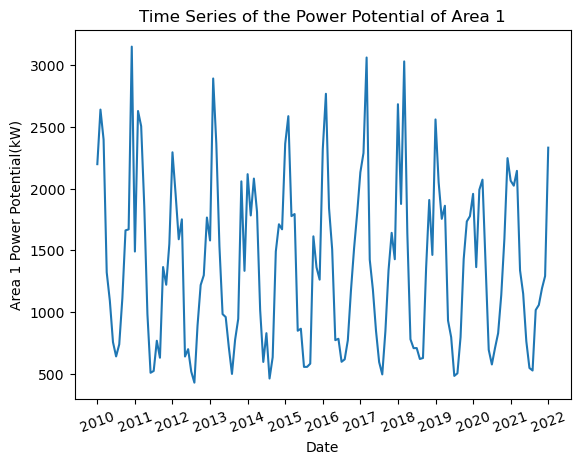

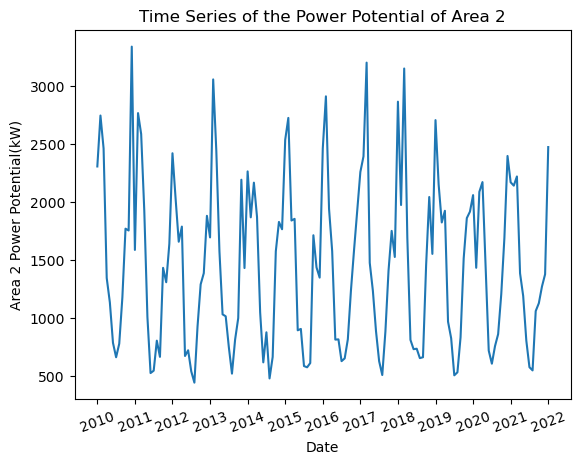

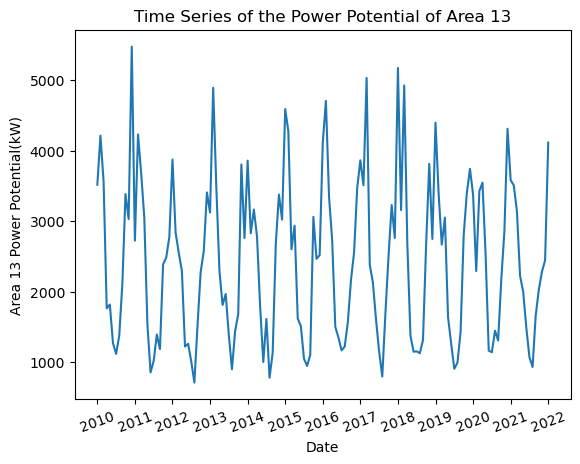

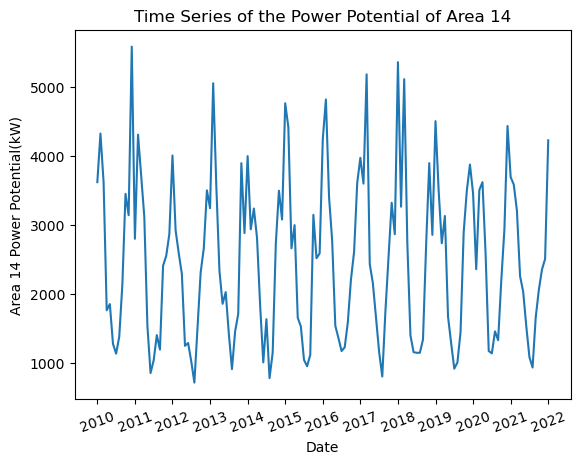

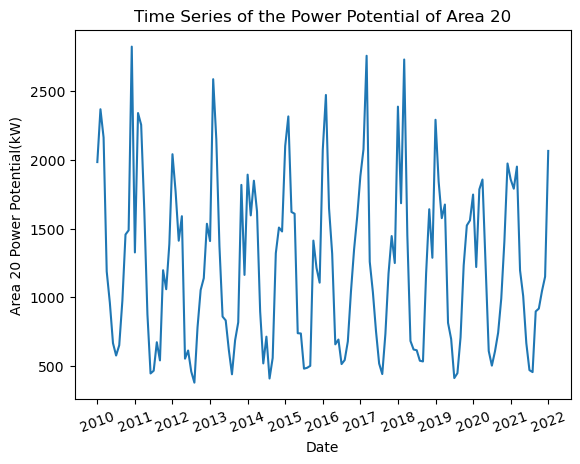

In [3]:
# graph first five wind potential areas
for i in notnas[:5]:    
    lp = sns.lineplot(x="Date", y="Area " + str(i+1) + " Power Potential(kW)", data=wind_potential)
    lp.set_xticks(range(0, wind_potential.shape[0], 12))
    lp.set_xticklabels([s[:4] for s in wind_potential.iloc[range(0, wind_potential.shape[0], 12),0]])
    plt.xticks(rotation=20)
    plt.title("Time Series of the Power Potential of Area " + str(i+1))
    plt.show()

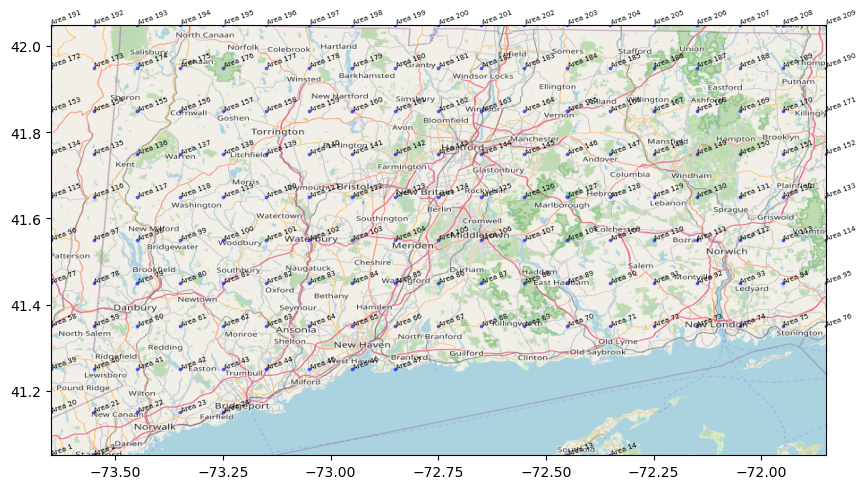

In [4]:
# graph map of areas
pic = plt.imread("map.png")
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(coords["long"], coords["lat"], zorder=1, alpha= 0.5, c='blue', s=3)
for i in notnas:
    ax.annotate("Area " + str(i+1), (coords["long"][i], coords["lat"][i]), fontsize=5, rotation=20)
ax.set_xlim(box[0], box[1])
ax.set_ylim(box[2], box[3])
ax.imshow(pic, zorder=0, extent=box, aspect='equal')
plt.savefig("output.png", dpi=300)

In [5]:
# find bounding boxes for the federal areas
fed_land = []
for i in range(len(open_space["geometry"])):
    fed_land.append(np.array(json.loads(open_space["geometry"][0].to_json())["bbox"]))
fed_land = np.array(fed_land)

In [6]:
# find score based on distance to nearest federal land
# 0 = in the land
# score is inverse of the minimum distance
def collides(p, box):
    return p["long"] >= box[0] and  p["lat"] >= box[1] and p["long"] <= box[2] and p["long"] <= box[3]

def dist(p, rect):
    dlong = np.max([rect[0] - p["long"], 0, p["long"] - rect[2]])
    dlat = np.max([rect[1] - p["lat"], 0, p["lat"] - rect[3]])
    return np.sqrt(dlong**2 + dlat**2)

def in_box(p):
    min_dist = np.Inf
    for box in fed_land:
        if collides(p, box):
            return 0
        d = dist(p, box)
        if d < min_dist:
            min_dist = d
    return min_dist**-1

coords["fed_land_score"] = coords[["lat", "long"]].apply(in_box, axis=1)
coords = coords.dropna()

In [7]:
# find the mean wind potential in addition to appending it to the distance to nearest federal land
corrs = {"area": [],  "mean_wind_potential": [], "fed_land_score": []}
for i in coords["area"]:
    corrs["area"].append(i)
    corrs["mean_wind_potential"].append(np.mean(wind_potential["Area " + str(i+1) + " Power Potential(kW)"]))
    corrs["fed_land_score"].append(np.float(coords[coords["area"] == i]["fed_land_score"]))
corrs_df = pd.DataFrame(corrs)

C:\Users\pieno\AppData\Local\Temp\ipykernel_16816\95142463.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corrs["fed_land_score"].append(np.float(coords[coords["area"] == i]["fed_land_score"]))


In [8]:
# normalize
scaler = MinMaxScaler()
corrs_df[["mean_wind_potential", "fed_land_score"]] = scaler.fit_transform(corrs_df[["mean_wind_potential", "fed_land_score"]])

Text(0.5, 1.0, 'Scaled Distance vs. Scaled Wind Potential')

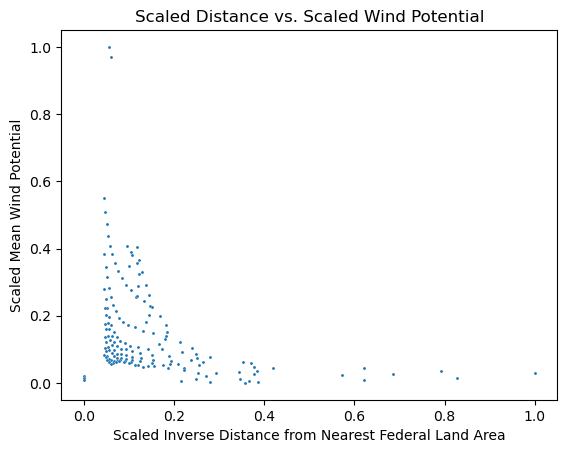

In [9]:
# graph plot
sns.scatterplot(x="fed_land_score", y="mean_wind_potential", data=corrs_df, s=5)
plt.xlabel("Scaled Inverse Distance from Nearest Federal Land Area")
plt.ylabel("Scaled Mean Wind Potential")
plt.title("Scaled Distance vs. Scaled Wind Potential")

<AxesSubplot:xlabel='month', ylabel='mean_wind_potential'>

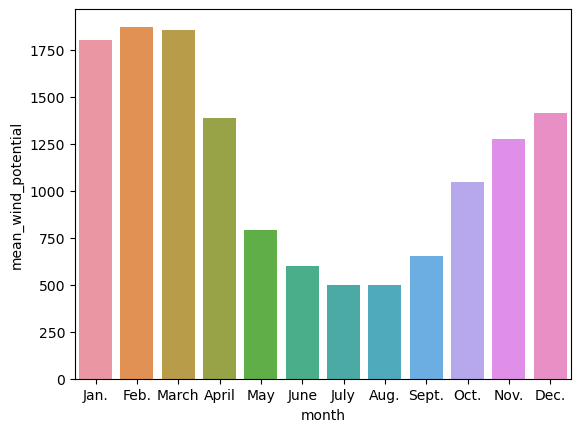

In [39]:
month_means = wind_potential.iloc[:,1:].agg("mean", axis="columns")
mm = [0 for _ in range(12)]
for i in range(len(month_means)):
    mm[i % 12] += month_means[i]
for i in range(12):
    if i == 0:
        mm[i] /= 12
    else:
        mm[i] /= 11
months = ["Jan.", "Feb.", "March", "April", "May", "June", "July", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."]
month_data = pd.DataFrame({"month": months, "mean_wind_potential": mm})
sns.barplot(data=month_data, x="month", y="mean_wind_potential")
plt.xlabel("Month of Year")
plt.ylabel("Mean Wind Potential (kW)")
plt.title("Mean Wind Potential by time of year in areas of Connecticut")

In [ ]:
# calculate correlation
corr, _ = pearsonr(corrs_df["fed_land_score"], corrs_df["mean_wind_potential"])
corr